# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
!pip install torchvision
!pip install hpbandster

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 92kB 5.1MB/s 
     |████████████████████████████████| 972kB 10.0MB/s 
  Created wheel for hpbandster: filename=hpbandster-0.7.4-cp36-none-any.whl size=80007 sha256=8eec35de3a83f6f18544d6b4c862ec3860bda6f87a09c2ce044c0d8399bc71bb
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.12-cp36-cp36m-linux_x86_64.whl size=2925951 sha256=c09b8ae92a97c9d07f817a53ecb76d118a5178f323f8075a3bf61a7fee5a5dde
  Stored in directory: /root/.cache/pip/wheels/ae/b2/85/feafec2387f97065d914a72c42ff3a0f6f60d8e1fd03c6bd4b
Successfully built hpbandster ConfigSpace


In [2]:
!pip install wget
!pip install zipfile36

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=b0a4aff22cf2018c139e38cced45ba4ba07288dde7e74a90c1b07f2fae82f0d6
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import wget
import zipfile
dir_path = 'content/'
filename=wget.download('https://ndownloader.figshare.com/files/21001311')
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("")
!rm fashion_mnist.zip
wget.download('https://raw.githubusercontent.com/automl/LCBench/master/api.py')
wget.download('https://raw.githubusercontent.com/infomon/Extrapolation-of-Learning-Curves/master/utils.py')
!mkdir content/models
!mkdir models

mkdir: cannot create directory ‘content/models’: No such file or directory


In [0]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from content.api import Benchmark
import content.utils as utils
import torch

import os

In [0]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

In [6]:
bench_dir = dir_path+"fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [7]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    #val_data, val_targets = cut_data(val_data, cut_position)
    #test_data, test_targets = cut_data(test_data, cut_position)
    val_data, val_targets = cut_data(val_data, 51)
    test_data, test_targets = cut_data(test_data, 51)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

## Sample use of data

In [8]:
# Config
print("Config example:", train_data[0]["config"])

Config example: {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}


In [9]:
train_data[1]["config"]

{'activation': 'relu',
 'batch_size': 457,
 'cosine_annealing_T_max': 50,
 'cosine_annealing_eta_min': 1e-08,
 'imputation_strategy': 'mean',
 'learning_rate': 0.01239328605026128,
 'learning_rate_scheduler': 'cosine_annealing',
 'loss': 'cross_entropy_weighted',
 'max_dropout': 0.5472322491757223,
 'max_units': 950,
 'mlp_shape': 'funnel',
 'momentum': 0.16411425552061212,
 'network': 'shapedmlpnet',
 'normalization_strategy': 'standardize',
 'num_layers': 4,
 'optimizer': 'sgd',
 'weight_decay': 0.09762768273307641}

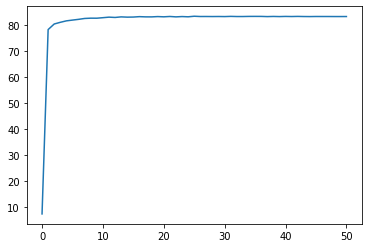

In [10]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

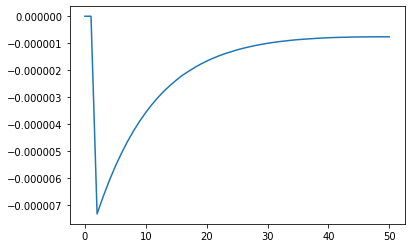

In [11]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

## A simple baseline

In [0]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [13]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 0.0


In [14]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 0.0


## Conditional Multi-Step Univariate LSTM

In [0]:
multivariate = False
nof_multi = 7
input_size = nof_multi if multivariate else 1

### Data Preperation

In [0]:
if multivariate:
  train_data_loader = utils.prep_data(train_data, train_targets, batch_size=32,
                                      temporal_keys=['Train/val_accuracy','Train/loss','Train/train_accuracy','Train/train_cross_entropy','Train/val_cross_entropy','Train/gradient_mean','Train/lr'],
                                      normalization_factor_temporal_data=[100,1,100,1,1,1,1], one_shot=True)
  val_data_loader = utils.prep_data(val_data, val_targets, batch_size=32,
                                    temporal_keys=['Train/val_accuracy','Train/loss','Train/train_accuracy','Train/train_cross_entropy','Train/val_cross_entropy','Train/gradient_mean','Train/lr'],
                                    normalization_factor_temporal_data=[100,1,100,1,1,1,1], one_shot=True)
  test_data_loader = utils.prep_data(test_data, test_targets, batch_size=32,
                                    temporal_keys=['Train/val_accuracy','Train/loss','Train/train_accuracy','Train/train_cross_entropy','Train/val_cross_entropy','Train/gradient_mean','Train/lr'],
                                    normalization_factor_temporal_data=[100,1,100,1,1,1,1],one_shot=True)
else:
  train_data_loader = utils.prep_data(train_data, train_targets, batch_size=32, normalization_factor_temporal_data=[100],one_shot=True)
  val_data_loader = utils.prep_data(val_data, val_targets, batch_size=32, normalization_factor_temporal_data=[100], one_shot=True)
  test_data_loader = utils.prep_data(test_data, test_targets, batch_size=32, normalization_factor_temporal_data=[100],one_shot=True)

### Models

In [0]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, nof_configs, num_layers, dropout = 0.5, bidirectional=False):
        super(EncoderRNN, self).__init__()
        
        self.nof_configs = nof_configs
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size=input_size, 
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  dropout=dropout,
                                  bidirectional=bidirectional)

        self.relu = torch.nn.functional.relu

        self.encode_fc1 = torch.nn.Linear(self.nof_configs,int(self.hidden_size/2))
        self.encode_bn1 = torch.nn.BatchNorm1d(int(self.hidden_size/2))
        self.encode_fc2 = torch.nn.Linear(int(self.hidden_size/2),self.hidden_size)
        self.encode_bn2 = torch.nn.BatchNorm1d(self.hidden_size)

    def forward(self, seq, config):
        h0 = self.initHidden(config)
        c0 = self.initCell(seq.size()[1])
        seq = seq.permute(2,1,0)
        output, (hidden,cell) = self.lstm(seq, (h0,c0))
        return output, hidden, cell

    def initHidden(self, config):
        x = self.relu(self.encode_bn1(self.encode_fc1(config)))
        x = self.relu(self.encode_bn2(self.encode_fc2(x)))
        return torch.stack([x for _ in range(self.num_layers*self.num_directions)])

    def initCell(self, batch_size):
        return torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)

In [0]:
class DecoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout = 0.5):
        super(DecoderRNN, self).__init__()
        
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size=input_size, 
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  dropout=dropout,
                                  bidirectional=False)
        
        self.fc_out = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.functional.relu

    def forward(self, seq, h0, c0):
        seq = seq.unsqueeze(0)
        seq = seq.unsqueeze(-1)
        output, (hidden,cell) = self.lstm(seq, (h0,c0))
        output = self.fc_out(output)
        return output.squeeze(), hidden, cell


In [0]:
class Seq2Seq(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

    assert encoder.hidden_size == decoder.hidden_size
    #assert encoder.num_layers == decoder.num_layers

  def forward(self, source, target, teacher_forcing_ratio = 0.5):
    batch_size = target.size()[0]
    target_len = target.size()[1]

    outputs = torch.zeros(target_len, batch_size, 1)

    seq , config = source
    output, hidden, cell = self.encoder(seq, config)

    decoder_input = target[:,0]
    for t in range(1, target_len):
      output, hidden, cell = self.decoder(decoder_input, hidden, cell)
      outputs[t] = output.unsqueeze(-1)
      use_teacher_forcing = np.random.random() < teacher_forcing_ratio
      decoder_input = target[:,t] if use_teacher_forcing else output
    return outputs

### Train, eval & test

In [0]:
def preprocess_batch(batch):
  temporal = batch[:nof_multi if multivariate else 1]
  temporal = torch.stack([t for t in temporal],dim=0)
  configs = batch[-2]
  targets = batch[-1]
  return temporal, configs, targets

In [0]:
def train(model, optimizer, criterion, clip=5):
    model.train()
    epoch_loss = []
    for batch in train_data_loader:
      temporal, configs, targets = preprocess_batch(batch)
      optimizer.zero_grad()
      output = model([temporal,configs],targets)
      output = output.squeeze()
      output = torch.t(output)
      loss = criterion(output, targets)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
      optimizer.step()
      epoch_loss.append(loss.item())
    return np.array(epoch_loss).mean()

In [0]:
def evaluate(model, criterion):
  model.eval()
  epoch_loss = []
  with torch.no_grad():
    for batch in val_data_loader:
      temporal, configs, targets = preprocess_batch(batch)
      output = model([temporal, configs], targets, 0)
      output = output.squeeze()
      output = torch.t(output)
      loss = criterion(output, targets)
      epoch_loss.append(loss.item())
  return np.array(epoch_loss).mean()

In [0]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [0]:
def test(model, criterion):
    model.load_state_dict(torch.load('content/models/model.pt'))
    model.eval()
    epoch_loss=[]
    with torch.no_grad():
      for batch in test_data_loader:
        temporal, configs, targets = preprocess_batch(batch)
        output = model([temporal, configs], targets, 0)
        output = output.squeeze()
        output = torch.t(output)
        loss = criterion(output[:,-1], targets[:,-1])
        epoch_loss.append(loss.item())
        
    return np.array(epoch_loss).mean()

### BOHB

In [0]:
run_bohb=False

In [0]:
def get_model(config):
  def init_weights(m):
    for name, param in m.named_parameters():
      torch.nn.init.uniform_(param.data, -0.08, 0.08)
  
  input_size = 1
  outcome_dim = 1
  config_size = 7
  bidirectional = bool(config['bidirectional'])
  encoder = EncoderRNN(input_size, config['hidden_dim'], config_size, config['num_layers'],
                       dropout=config['encoder_dropout'],bidirectional=bidirectional)
  decoder = DecoderRNN(input_size, config['hidden_dim'], outcome_dim, 
                       num_layers=2*config['num_layers'] if bidirectional else config['num_layers'],dropout=config['decoder_dropout'])
  model = Seq2Seq(encoder, decoder)
  model.apply(init_weights)
  return model

In [0]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 30
# largest budget BOHB will use
max_budget = 200

In [0]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader = train_data_loader, val_data_loader, test_data_loader

    @staticmethod
    def get_model(config: CS.Configuration) -> torch.nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        return get_model(config)
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ 
        Define a conditional hyperparameter search-space.
        """
        cs = CS.ConfigurationSpace()
        hidden_dim = CSH.UniformIntegerHyperparameter("hidden_dim",lower=5,upper=500,log=True)
        num_layers = CSH.UniformIntegerHyperparameter("num_layers",lower=1,upper=5)
        encoder_dropout = CSH.UniformFloatHyperparameter("encoder_dropout",lower=0.1,upper=0.8)
        decoder_dropout = CSH.UniformFloatHyperparameter("decoder_dropout",lower=0.1,upper=0.8)
        bidirectional = CSH.UniformIntegerHyperparameter("bidirectional",lower=0,upper=1)

        lr = CSH.UniformFloatHyperparameter("lr",lower=1e-6,upper=1e-1,log=True)
        weight_decay = CSH.UniformFloatHyperparameter("weight_decay",lower=1e-6,upper=1e-1,log=True)
        sgd_momentum = CSH.UniformFloatHyperparameter("sgd_momentum",lower=0.00,upper=0.99)
        optimizer = CSH.CategoricalHyperparameter('optimizer', choices=['Adam', 'SGD'])
        
        scheduler = CSH.CategoricalHyperparameter('scheduler', choices=['CosAnn', 'CosAnnWarm'])
        T_max = CSH.UniformIntegerHyperparameter("T_max",lower=10,upper=max_budget)
        T_0 = CSH.UniformIntegerHyperparameter("T_0",lower=10,upper=int(max_budget/3))

        cs.add_hyperparameters([hidden_dim, num_layers, encoder_dropout, decoder_dropout, bidirectional,
                                lr, weight_decay, sgd_momentum,optimizer,scheduler,T_max,T_0])
    
        condition1 = CS.EqualsCondition(sgd_momentum,optimizer,'SGD')
        cs.add_condition(condition1)
        condition2 = CS.EqualsCondition(T_max,scheduler,'CosAnn')
        cs.add_condition(condition2)
        condition3 = CS.EqualsCondition(T_0,scheduler,'CosAnnWarm')
        cs.add_condition(condition3)
        return cs

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> dict:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)

        if config['optimizer'] == 'Adam':
          optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        else:
          optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])
        
        if config['scheduler'] == 'CosAnnWarm':
          scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'])
        else:
          scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['T_max'])

        criterion = torch.nn.MSELoss()
        clip = 5

        for epoch in range(int(budget)):
          loss = 0
          model.train()
          for val_acc, configs, targets in self.train_loader:
            optimizer.zero_grad()
            output = model([val_acc,configs],targets)
            output = output.squeeze()
            output = torch.t(output)
            loss = criterion(output, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
            optimizer.step()
          scheduler.step()
        
        train_loss = evaluate(model, self.train_loader)
        validation_loss = evaluate(model, self.validation_loader)
        test_loss = evaluate(model, self.test_loader)
        
        return ({
                'loss': validation_loss,  # remember: HpBandSter minimizes the loss!
                'info': {'test_loss': test_loss,
                         'train_loss': train_loss,
                         'validation_loss': validation_loss,
                         'model': str(model)}
                })

In [0]:
if run_bohb:
  worker = PyTorchWorker(run_id='0')
  cs = worker.get_configspace()

  config = cs.sample_configuration().get_dictionary()
  print(config)

  res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
  print(res)

In [0]:
if run_bohb:
  result_file = os.path.join(working_dir, 'bohb_result.pkl')
  nic_name = 'lo0'
  port = 0
  run_id = 'bohb_run_1'
  n_bohb_iterations = 12

In [0]:
if run_bohb:
  try:
      # Start a nameserver
      worker = PyTorchWorker(run_id='0')
      ns = hpns.NameServer(run_id=run_id, host='127.0.0.1', port=port,
                          working_directory=working_dir)
      ns_host, ns_port = ns.start()
      # Start local worker
      w = PyTorchWorker(run_id=run_id, host='127.0.0.1', nameserver=ns_host,
                        nameserver_port=ns_port, timeout=120)
      w.run(background=True)

      # Run an optimizer
      bohb = BOHB(configspace=worker.get_configspace(),
                  run_id=run_id,
                  host='127.0.0.1',
                  nameserver=ns_host,
                  nameserver_port=ns_port,
                  min_budget=min_budget, max_budget=max_budget)

      result = bohb.run(n_iterations=n_bohb_iterations)
      print("Write result to file {}".format(result_file))
      with open(result_file, 'wb') as f:
          pickle.dump(result, f)
  finally:
      bohb.shutdown(shutdown_workers=True)
      ns.shutdown()

### Training Loop

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
      torch.nn.init.uniform_(param.data, -0.08, 0.08)

In [0]:
epochs = 2500

decoder_input_size = 1
output_size = 1
config_size = 7
hidden_size=50
encoder_dropout=0.5
decoder_dropout=0.5
num_layers=2
bidirectional = True
encoder = EncoderRNN(input_size, hidden_size=hidden_size, nof_configs=config_size, num_layers=num_layers,
                      dropout=encoder_dropout,bidirectional=bidirectional)
decoder = DecoderRNN(decoder_input_size, hidden_size=hidden_size, output_size=output_size, 
                      num_layers=2*num_layers if bidirectional else num_layers,dropout=decoder_dropout)
model = Seq2Seq(encoder, decoder)
model.apply(init_weights)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=10e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

In [0]:
best_val_loss = float('inf')

for epoch in range(epochs):
  train_loss = train(model, optimizer, criterion)
  val_loss = evaluate(model, criterion)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(),"content/models/model.pt")    
    print('Val loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_val_loss,val_loss))
    best_val_loss = val_loss

  print(f'Epoch: {epoch}\t Train Loss: {train_loss:.3f}\t Val. Loss: {val_loss:.3f}')
  scheduler.step()

Val loss decreased (inf --> 3622.436050).  Saving model ...
Epoch: 0	 Train Loss: 4760.393	 Val. Loss: 3622.436
Val loss decreased (3622.436050 --> 1938.671989).  Saving model ...
Epoch: 1	 Train Loss: 2773.007	 Val. Loss: 1938.672
Val loss decreased (1938.671989 --> 811.669666).  Saving model ...
Epoch: 2	 Train Loss: 1363.551	 Val. Loss: 811.670
Val loss decreased (811.669666 --> 215.193925).  Saving model ...
Epoch: 3	 Train Loss: 496.718	 Val. Loss: 215.194
Val loss decreased (215.193925 --> 97.085549).  Saving model ...
Epoch: 4	 Train Loss: 151.644	 Val. Loss: 97.086
Epoch: 5	 Train Loss: 128.940	 Val. Loss: 122.513
Val loss decreased (97.085549 --> 34.376609).  Saving model ...
Epoch: 6	 Train Loss: 96.702	 Val. Loss: 34.377
Val loss decreased (34.376609 --> 24.790811).  Saving model ...
Epoch: 7	 Train Loss: 38.353	 Val. Loss: 24.791
Epoch: 8	 Train Loss: 31.923	 Val. Loss: 57.102
Epoch: 9	 Train Loss: 30.429	 Val. Loss: 26.767
Val loss decreased (24.790811 --> 18.205824).  Sav

### Test results

In [0]:
mse_test = test(model, criterion)
print("MSE Test loss: {:.3f}".format(np.mean(mse_test)))
rmse_test = test(model, RMSELoss)
print("RMSE Test loss: {:.3f}".format(np.mean(rmse_test)))

In [0]:
import matplotlib.pyplot as plt
def plot_curve(model):
  model.load_state_dict(torch.load('content/models/model.pt'))
  model.eval()
  with torch.no_grad():
      for batch in test_data_loader:
        temporal, configs, targets = preprocess_batch(batch)
        output = model([temporal, configs], targets, 0)
        output = output.squeeze()
        output = torch.t(output)
        plt.plot(np.arange(51),targets[2],c='g')
        plt.plot(np.arange(51),output[2],c='r')
        plt.show()
        break

plot_curve(model)